### Matter power spectrum related functions in flat $\Lambda$CDM cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import interpolate

# cosmo packages used
from colossus.cosmology import cosmology
import camb

In [2]:
camb.__version__

'1.1.3'

In [3]:
rcParams.update({'font.size': 22})

---

### Setup cosmology and calculator

In [4]:
cosmo = cosmology.setCosmology('planck18') # Planck 2018 CMB + BAO
print(cosmo)

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [5]:
h = cosmo.H0 / 100.
As = 2.105e-9
camb_pars = camb.CAMBparams()
camb_pars.set_cosmology(H0=cosmo.H0, ombh2=cosmo.Ob0*h**2, omch2=(cosmo.Om0-cosmo.Ob0)*h**2, omk=0.0,
                        TCMB=cosmo.Tcmb0, nnu=cosmo.Neff)
camb_pars.InitPower.set_params(As=As, ns=cosmo.ns)

camb_pars.set_matter_power(redshifts=(0.0,), kmax=10, nonlinear=True,
                           accurate_massive_neutrino_transfers=True)
camb_pars.set_for_lmax(2500, lens_potential_accuracy=2)
camb_pars.set_nonlinear_lensing(True)

camb_pars.set_accuracy(AccuracyBoost=3.0)

print(camb_pars)

# calculate all results
camb_results = camb.get_results(camb_pars)

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_both
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = True
   kmax = 10.0
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2650
 max_l_tensor = 600
 max_eta_k = 36000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.02243159044
 omch2 = 0.11998611947599999
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.66
 TCMB = 2.7255
 YHe = 0.24542273390457917
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
 

---

### Transfer function today
- $T(k, z=0)$

In [6]:
matter_trans = camb_results.get_matter_transfer_data()
ks = matter_trans.q # in Mpc^{-1}
Tk_tot = matter_trans.transfer_data[camb.model.Transfer_tot-1, :, -1]
# total matter, i.e. CDM + baryon + massive neutrino
# note the redshift index above should be -1 instead of 0

print(matter_trans.transfer_data.shape)
print('kmin = {:.3e}, kmax = {:.3f}  Mpc^-1'.format(np.min(ks), np.max(ks)))

(13, 1408, 150)
kmin = 2.357e-06, kmax = 15.750  Mpc^-1


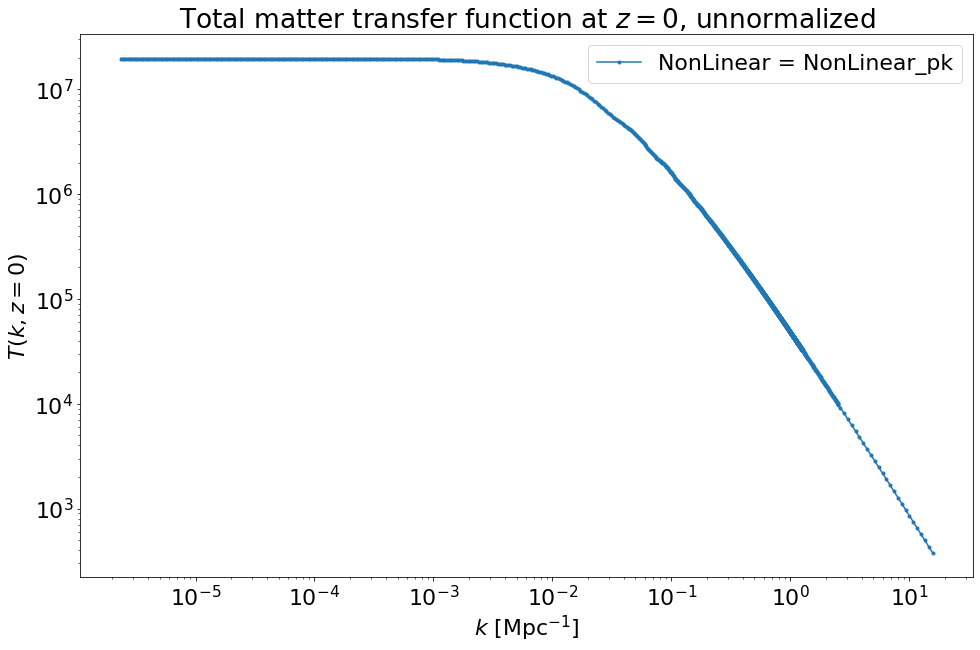

In [7]:
fig, (ax) = plt.subplots(1, 1, figsize=(16, 10))

ax.plot(ks, Tk_tot, ls='-', marker='.', label='NonLinear = NonLinear_pk')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_ylabel(r'$T(k,z=0)$')
ax.set_title(r'Total matter transfer function at $z = 0$, unnormalized')
ax.legend()

plt.show()

#### Interpolation accuracy

In [8]:
# setup interpolator
Tk_interp = interpolate.interp1d(ks, Tk_tot, kind='cubic', bounds_error=False, fill_value='extrapolate')

In [9]:
pars_t = camb_pars.copy() # for test
pars_t.Transfer.kmax = 3 # lower than the interpolator
pars_t.Transfer.k_per_logint = 1000 # test sample points
results_t = camb.get_results(pars_t)
trans_t = results_t.get_matter_transfer_data()
ks_t = trans_t.q
print(ks_t.shape)
Tk_t = trans_t.transfer_data[camb.model.Transfer_tot-1, :, -1]

Tk_s = Tk_interp(ks_t)

(3157,)


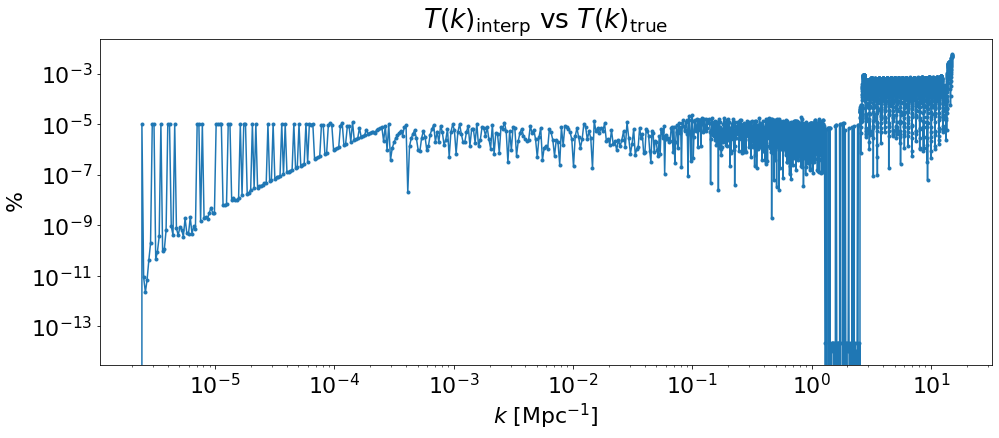

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(ks_t, np.abs(100*(Tk_s/Tk_t-1)), ls='-', marker='.')

ax.set_ylabel(r'$\%$'); ax.set_title(r'$T(k)_{\rm interp}$ vs $T(k)_{\rm true}$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]'); ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

- Set `camb_pars.Accuracy.AccuracyBoost = 3.0` should be good.

---

### Matter power spectrum

- Check the primordial scalar curvature power spectrum in CAMB
- $\mathcal{P}_s(k) = A_s \left(\frac{k}{k_*}\right)^{n_s-1}$, $k_* = 0.05\,{\rm Mpc}^{-1}$

In [11]:
def c_Ps(k):
    return As * (k/0.05)**(cosmo.ns - 1)

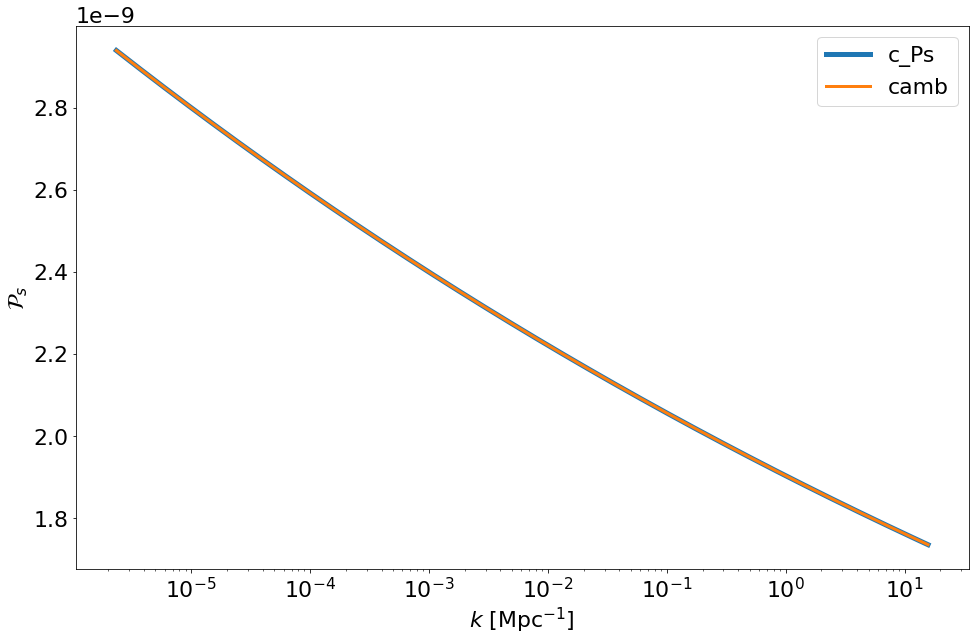

In [12]:
c_Pss = c_Ps(ks)
Ps_camb = camb_results.Params.scalar_power(ks)

fig, (ax) = plt.subplots(1, 1, figsize=(16, 10))

ax.plot(ks, c_Pss, label='c_Ps', lw=5)
ax.plot(ks, Ps_camb, label='camb', lw=3)

ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel('$k$ [Mpc$^{-1}$]'); ax.set_ylabel(r'$\mathcal{P}_s$')
ax.legend()

plt.show()

- Check $P(k,z=0) = \frac{2\pi^2}{k^3}\,\left[k^2T(k,z=0)\right]^2\,\mathcal{P}_s(k)$

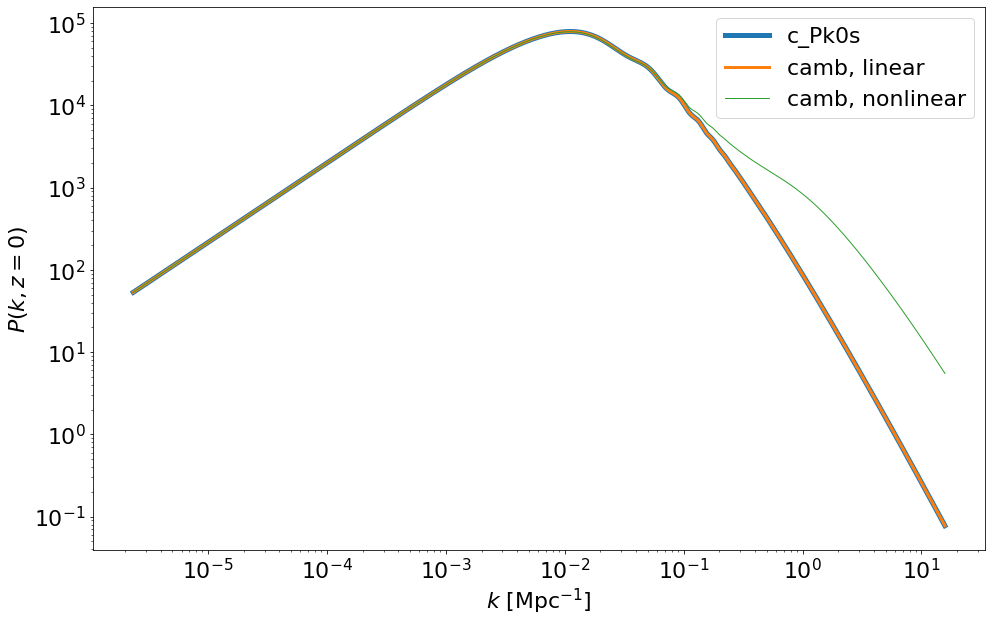

In [13]:
c_Pk0s = 2 * np.pi**2 / ks**3 * (ks**2 * Tk_tot)**2 * Ps_camb
_k, _z, PK = camb_results.get_linear_matter_power_spectrum(hubble_units=False, k_hunit=False) # _k is the same as ks
Pk0s_linear = PK[0]
_k, _z, PK = camb_results.get_nonlinear_matter_power_spectrum(hubble_units=False, k_hunit=False)
Pk0s_nonlin = PK[0]

fig, (ax) = plt.subplots(1, 1, figsize=(16, 10))

ax.plot(ks, c_Pk0s, label='c_Pk0s', lw=5)
ax.plot(ks, Pk0s_linear, label='camb, linear', lw=3)
ax.plot(ks, Pk0s_nonlin, label='camb, nonlinear', lw=1)

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('$k$ [Mpc$^{-1}$]'); ax.set_ylabel(r'$P(k,z=0)$')
ax.legend()

plt.show()

- Verify $P(k,z) = D(z)^2 P(k,z=0)$

In [14]:
Dz0 = cosmo.growthFactorUnnormalized(0.0)
def D(z):
    return cosmo.growthFactorUnnormalized(z) / Dz0

def Pkz(z):
    return D(z) * D(z) * Pk0s_linear # the two matter fields are the same

def Pkz_nl(z): # should not be right, linear evolution for nonlinear power, just check what would happen
    return D(z) * D(z) * Pk0s_nonlin 

In [15]:
camb_Pk_interp = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=1100, nonlinear=False, kmax=15, hubble_units=False, k_hunit=False)

In [17]:
camb_Pk_interp_nl = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=1100, nonlinear=True, kmax=15, hubble_units=False, k_hunit=False)

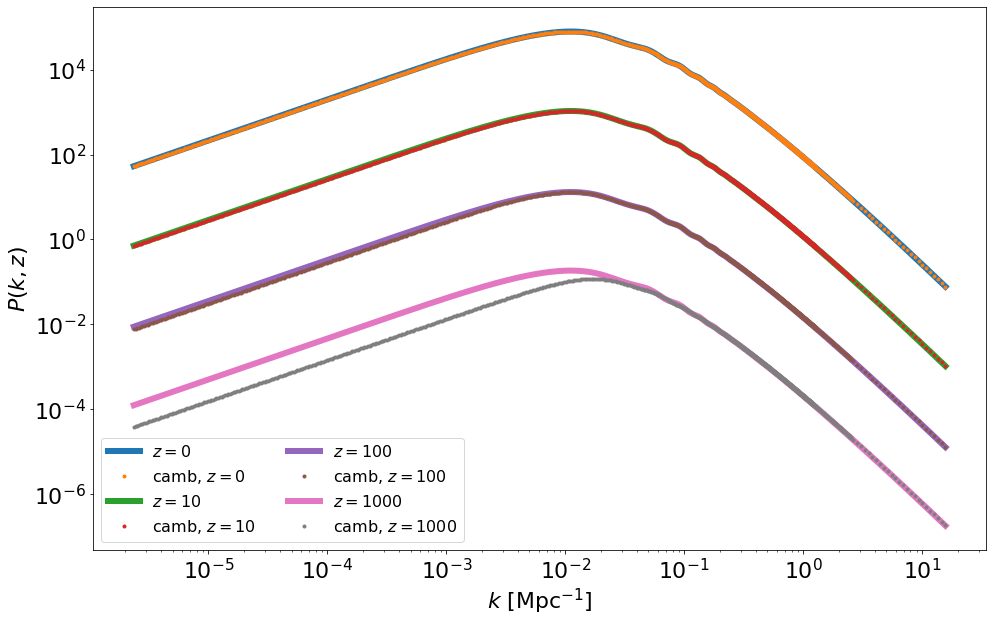

In [18]:
zs = np.array([0.0, 10.0, 100.0, 1000.0])

fig, (ax) = plt.subplots(1, 1, figsize=(16, 10))

for z_ in zs:
    Pkzs = Pkz(z_)
    camb_Pkzs = camb_Pk_interp.P(z_, ks)
    ax.plot(ks, Pkzs, label=r'$z = {:g}$'.format(z_), lw=6)
    ax.plot(ks, camb_Pkzs, label=r'camb, $z = {:g}$'.format(z_), ls='None', marker='.')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('$k$ [Mpc$^{-1}$]'); ax.set_ylabel(r'$P(k,z)$')
ax.legend(ncol=2, fontsize=16)
plt.show()

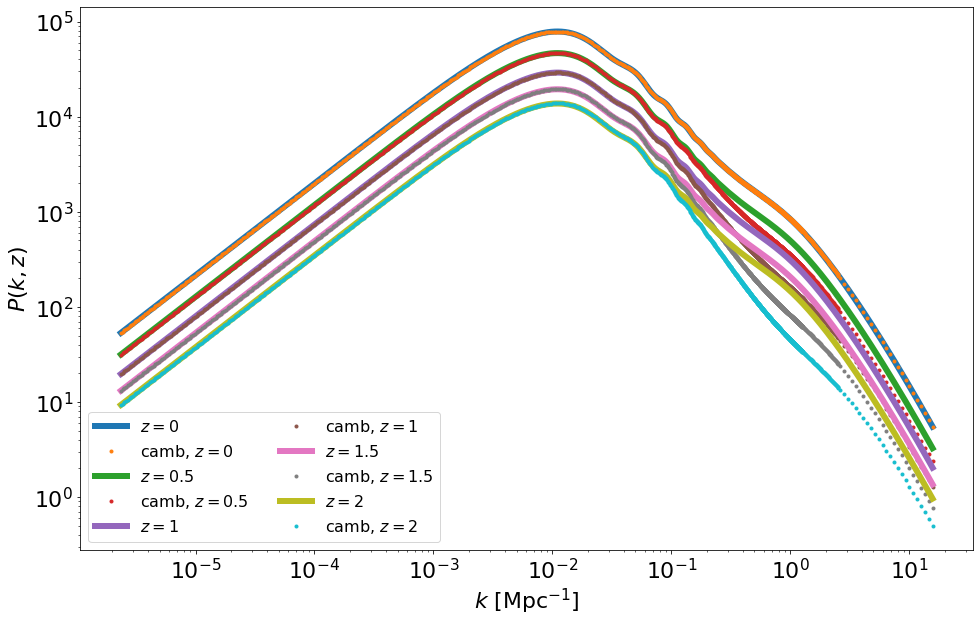

In [20]:
# non linear
zs = np.array([0.0, 0.5, 1.0, 1.5, 2.0])

fig, (ax) = plt.subplots(1, 1, figsize=(16, 10))

for z_ in zs:
    Pkzs = Pkz_nl(z_)
    camb_Pkzs = camb_Pk_interp_nl.P(z_, ks)
    ax.plot(ks, Pkzs, label=r'$z = {:g}$'.format(z_), lw=6)
    ax.plot(ks, camb_Pkzs, label=r'camb, $z = {:g}$'.format(z_), ls='None', marker='.')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('$k$ [Mpc$^{-1}$]'); ax.set_ylabel(r'$P(k,z)$')
ax.legend(ncol=2, fontsize=16)
plt.show()

#### Interpolation accuracy

- just use the same setting as $T(k)$, i.e. `camb_pars.Accuracy.AccuracyBoost = 3.0`

#### With different matter sources
- $P(k,z=0)$
- https://camb.readthedocs.io/en/latest/transfer_variables.html

In [17]:
Pk_tot_tot = camb_results.get_linear_matter_power_spectrum(var1='delta_tot', var2='delta_tot', hubble_units=False, k_hunit=False)[2][0]
Pk_tot_nonu = camb_results.get_linear_matter_power_spectrum(var1='delta_tot', var2='delta_nonu', hubble_units=False, k_hunit=False)[2][0]
Pk_nonu_nonu = camb_results.get_linear_matter_power_spectrum(var1='delta_nonu', var2='delta_nonu', hubble_units=False, k_hunit=False)[2][0]

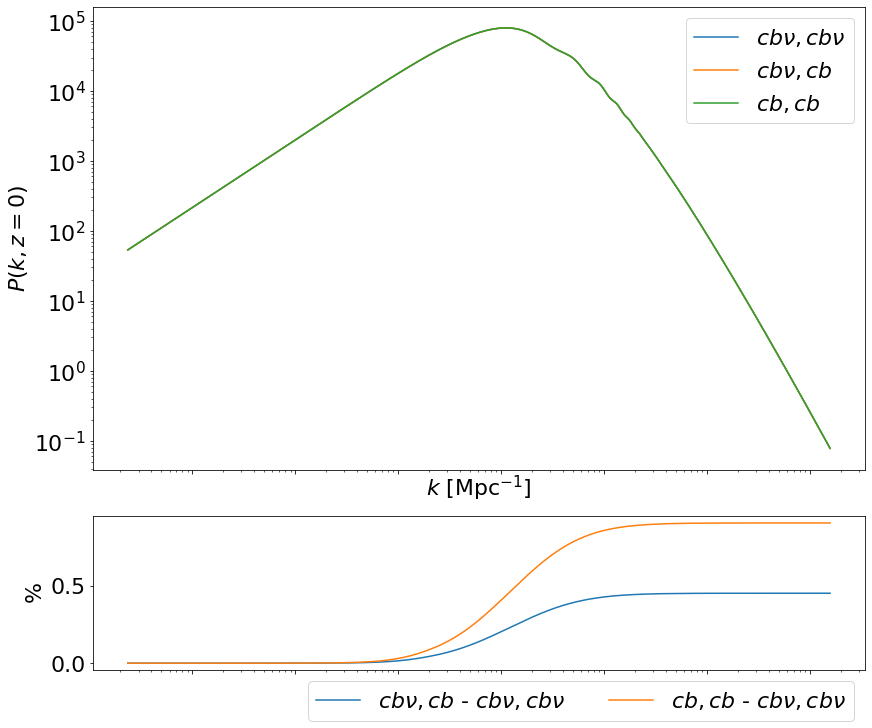

In [21]:
fig, (ax, ay) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]}, constrained_layout=True, sharex=True)

ax.plot(ks, Pk_tot_tot, label=r'$cb\nu,cb\nu$')
ax.plot(ks, Pk_tot_nonu, label=r'$cb\nu,cb$')
ax.plot(ks, Pk_nonu_nonu, label=r'$cb,cb$')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('$k$ [Mpc$^{-1}$]'); ax.set_ylabel(r'$P(k,z=0)$')
ax.legend()

ay.plot(ks, 100*(Pk_tot_nonu/Pk_tot_tot-1), label=r'$cb\nu,cb$ - $cb\nu,cb\nu$')
ay.plot(ks, 100*(Pk_nonu_nonu/Pk_tot_tot-1), label=r'$cb,cb$ - $cb\nu,cb\nu$')
ay.set_ylabel(r'$\%$')
ay.tick_params(axis='x', which='both', labelbottom=False)
ay.legend(ncol=2, bbox_to_anchor=(1,0))

plt.show()

---

### Appendix: Normalization of matter power spectrum with $\sigma_8$ or $A_s$

- $\sigma^2(R, z) = \int_0^\infty \frac{dk}{k} \frac{k^3 P(k,z)}{2\pi^2} W^2(kR)$, where $W(kR) = \frac{3j_1(kR)}{kR}$ assuming a spherical top-hat smoothing. (Eq.(1) in https://arxiv.org/pdf/astro-ph/0010039.pdf)

---